In [1]:
import config
import os, numpy as np, pandas, sklearn
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [4]:
context = data.init()

Setting up params

max min f 25.0 0.1
 >> Context(max_t=10.0, dt=0.02, n_instances=500, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)


In [5]:
# fn = (config.dataset_dir + '4-floor-120bpm.mid')
# mid = io.import_midifile(fn)

## Setup a generator

1. What is the least amount of 'hidden' nodes needed to learn a straight rythm (e.g. 8th notes with different frequencies)
2. Can we create a model of a generic function sin(2 pi f t + phase)
    - using x: t -> y: sin(2p t)
    - using x: [f, t, phase] -> y: sin(2p f t + phase)
    - using x: sin([t1, t2, t3) -> y: [f, t, phase]
        - such a model should be able to learn complex patterns, such as sin(f1+p1) + sin(f2+p2) + sin(f3+p3)

In [6]:
n = 10
max_f = 20
min_f = 10
x_train = g.gen_data(context, n, max_f=max_f, min_f=min_f)
# x_train = np.zeros([10,100,127])
y_train = x_train

WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  10.035416666666666
 |>  500


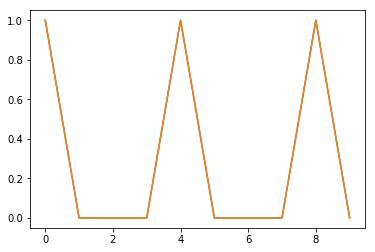

In [7]:
plt.plot(x_train[0,:10,0:3])

In [8]:
# [sum(x) for x in x_train]
x_train.shape

(10, 500, 2)

In [9]:
y_train = x_train
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train.shape[1:]
# output_length = y_train.shape[1]
# output_length = (y_train[0]).shape[0] # = length of an individual label
hidden_layer_length = 500
x_train.shape

(10, 500, 2)

In [41]:
# functional syntax: lambda x: lambda y: z
def encoder(input_shape, output_length, dropout=0.10):
    input_layer = Input(shape=input_shape)
    x = input_layer
    x = Flatten()(x)
#     x = Dense(output_length * 2, activation='relu')(x)    
#     x = Dropout(dropout)(x)
#     x = Dense(output_length * 2, activation='relu')(x)
    x = Dense(output_length, activation='relu')(x)
#     x = Dense(output_length, activation='sigmoid')(x)
#     x = Dropout(dropout)(x)
#     x = Dense(output_length, activation='relu', activity_regularizer=regularizers.l1(10e-5))(x)
    #     model.add(Dropout(dropout))    
    model = Model(inputs=input_layer, outputs=x)
    return model


def decoder(input_length, output_shape, dropout=0.10):
    input_layer = Input(shape=(input_length,))
    x = input_layer
    shape = output_shape
    # shape = (10,100) # increase n dimensions
    
    x = Dense(np.prod(shape), activation='relu')(x)
#     x = Dropout(dropout)(x)
    x = Dense(np.prod(shape), activation='relu')(x)
#     x = Dropout(dropout)(x)
#     x = Dense(np.prod(shape), activation='sigmoid')(x) # 4*4*8 = 128
    x = Reshape(shape)(x)
#     x = UpSampling1D(10)(x)
    # make sure the conv layer increases the amount of dimensions
#     dims = keras.backend.int_shape(x)[1:]
#     n_steps = output_shape[0]
#     n_output_timesteps = output_shape[1]
#     filters = n_output_timesteps
#     conv_amt = 2
#     print('__+++==', n_output_timesteps)
#     x = Conv1D(filters, kernel_size=4, strides=2, activation='relu')(x) # 50,100

    dims = keras.backend.int_shape(x)[1:]
#     x = UpSampling1D(dims[0] * 2)(x)
#     x = Dense(output_shape[1], activation='relu')(x)
    #     x = LocallyConnected1D(output_shape[1], kernel_size=1, activation='relu')(x)
    # x = Dense(output_length, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=x)
    #     model.add(Dropout(dropout))
    return model


def autoencoder(input_shape, output_shape, hidden_layer_length=10, dropout=0.10, verbose=False):
    input_ = Input(shape=input_shape)
    encode = encoder(input_shape, hidden_layer_length, dropout)
    if verbose:
        encode.summary()
    decode = decoder(hidden_layer_length, output_shape, dropout)
    if verbose:
        decode.summary()
    model = Model(input_, decode(encode(input_)))
    return encode, decode, model

dropout = 0.1
encoder, decoder, auto = autoencoder(input_shape, output_shape, hidden_layer_length, dropout, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 500, 2)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 500)               500500    
Total params: 500,500
Trainable params: 500,500
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 500)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              501000    
_________________________________________________________________
dens

In [42]:
metrics = ['accuracy','mse','mae']
loss = 'binary_crossentropy'# binary_crossentropy categorical_crossentropy
optimizer = 'adam'
auto.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [43]:
batch_size = 16
# n epochs = n iterations over all the training data
epochs = 150

In [44]:
m = 4
# xx = np.stack([x_train[0] for _ in range(m)])
# yy = xx
# history = auto.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])
history = auto.fit(x_train[:m], y_train[:m], epochs=epochs, batch_size=batch_size,
          validation_split=1/6, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])

Train on 3 samples, validate on 1 samples
Epoch 1/150
3/3 [==============================] - 0s 51ms/step - loss: 2.5156 - acc: 0.7250 - mean_squared_error: 0.2433 - mean_absolute_error: 0.3087 - val_loss: 2.3867 - val_acc: 0.7570 - val_mean_squared_error: 0.2236 - val_mean_absolute_error: 0.2809
Epoch 2/150
3/3 [==============================] - 0s 19ms/step - loss: 2.1058 - acc: 0.7653 - mean_squared_error: 0.1962 - mean_absolute_error: 0.2651 - val_loss: 2.7060 - val_acc: 0.7490 - val_mean_squared_error: 0.2310 - val_mean_absolute_error: 0.2879
Epoch 3/150
3/3 [==============================] - 0s 21ms/step - loss: 1.9345 - acc: 0.8053 - mean_squared_error: 0.1696 - mean_absolute_error: 0.2323 - val_loss: 2.8377 - val_acc: 0.7280 - val_mean_squared_error: 0.2388 - val_mean_absolute_error: 0.2970
Epoch 4/150
3/3 [==============================] - 0s 20ms/step - loss: 1.8341 - acc: 0.8303 - mean_squared_error: 0.1599 - mean_absolute_error: 0.2133 - val_loss: 2.9776 - val_acc: 0.7210 -

Epoch 33/150
3/3 [==============================] - 0s 18ms/step - loss: 1.4417 - acc: 0.7503 - mean_squared_error: 1.0684 - mean_absolute_error: 0.4277 - val_loss: 3.6849 - val_acc: 0.7050 - val_mean_squared_error: 0.3293 - val_mean_absolute_error: 0.3228
Epoch 34/150
3/3 [==============================] - 0s 19ms/step - loss: 1.4403 - acc: 0.7497 - mean_squared_error: 1.0917 - mean_absolute_error: 0.4318 - val_loss: 3.6873 - val_acc: 0.7050 - val_mean_squared_error: 0.3308 - val_mean_absolute_error: 0.3236
Epoch 35/150
3/3 [==============================] - 0s 21ms/step - loss: 1.4356 - acc: 0.7497 - mean_squared_error: 1.1143 - mean_absolute_error: 0.4360 - val_loss: 3.7021 - val_acc: 0.7050 - val_mean_squared_error: 0.3323 - val_mean_absolute_error: 0.3243
Epoch 36/150
3/3 [==============================] - 0s 17ms/step - loss: 1.4349 - acc: 0.7480 - mean_squared_error: 1.1353 - mean_absolute_error: 0.4400 - val_loss: 3.7079 - val_acc: 0.7050 - val_mean_squared_error: 0.3337 - val_

Epoch 65/150
3/3 [==============================] - 0s 28ms/step - loss: 1.3914 - acc: 0.7447 - mean_squared_error: 1.5681 - mean_absolute_error: 0.5004 - val_loss: 3.7654 - val_acc: 0.6970 - val_mean_squared_error: 0.3872 - val_mean_absolute_error: 0.3452
Epoch 66/150
3/3 [==============================] - 0s 22ms/step - loss: 1.3914 - acc: 0.7453 - mean_squared_error: 1.5891 - mean_absolute_error: 0.5027 - val_loss: 3.7671 - val_acc: 0.6950 - val_mean_squared_error: 0.3901 - val_mean_absolute_error: 0.3463
Epoch 67/150
3/3 [==============================] - 0s 19ms/step - loss: 1.3876 - acc: 0.7453 - mean_squared_error: 1.6101 - mean_absolute_error: 0.5051 - val_loss: 3.7688 - val_acc: 0.6960 - val_mean_squared_error: 0.3923 - val_mean_absolute_error: 0.3471
Epoch 68/150
3/3 [==============================] - 0s 16ms/step - loss: 1.3817 - acc: 0.7453 - mean_squared_error: 1.6206 - mean_absolute_error: 0.5053 - val_loss: 3.7814 - val_acc: 0.6950 - val_mean_squared_error: 0.3946 - val_

Epoch 97/150
3/3 [==============================] - 0s 17ms/step - loss: 1.3484 - acc: 0.7420 - mean_squared_error: 2.0689 - mean_absolute_error: 0.5571 - val_loss: 3.8914 - val_acc: 0.6810 - val_mean_squared_error: 0.4317 - val_mean_absolute_error: 0.3667
Epoch 98/150
3/3 [==============================] - 0s 21ms/step - loss: 1.3442 - acc: 0.7413 - mean_squared_error: 2.0904 - mean_absolute_error: 0.5601 - val_loss: 3.8905 - val_acc: 0.6830 - val_mean_squared_error: 0.4330 - val_mean_absolute_error: 0.3673
Epoch 99/150
3/3 [==============================] - 0s 19ms/step - loss: 1.3430 - acc: 0.7417 - mean_squared_error: 2.1128 - mean_absolute_error: 0.5624 - val_loss: 3.8929 - val_acc: 0.6830 - val_mean_squared_error: 0.4344 - val_mean_absolute_error: 0.3679
Epoch 100/150
3/3 [==============================] - 0s 18ms/step - loss: 1.3429 - acc: 0.7417 - mean_squared_error: 2.1365 - mean_absolute_error: 0.5653 - val_loss: 3.9074 - val_acc: 0.6840 - val_mean_squared_error: 0.4359 - val

Epoch 129/150
3/3 [==============================] - 0s 16ms/step - loss: 1.3058 - acc: 0.7410 - mean_squared_error: 2.9665 - mean_absolute_error: 0.6573 - val_loss: 4.0802 - val_acc: 0.6700 - val_mean_squared_error: 0.4544 - val_mean_absolute_error: 0.3779
Epoch 130/150
3/3 [==============================] - 0s 17ms/step - loss: 1.3058 - acc: 0.7407 - mean_squared_error: 2.9978 - mean_absolute_error: 0.6601 - val_loss: 4.0650 - val_acc: 0.6690 - val_mean_squared_error: 0.4558 - val_mean_absolute_error: 0.3783
Epoch 131/150
3/3 [==============================] - 0s 17ms/step - loss: 1.3057 - acc: 0.7403 - mean_squared_error: 3.0260 - mean_absolute_error: 0.6623 - val_loss: 4.0643 - val_acc: 0.6680 - val_mean_squared_error: 0.4574 - val_mean_absolute_error: 0.3787
Epoch 132/150
3/3 [==============================] - 0s 16ms/step - loss: 1.3024 - acc: 0.7400 - mean_squared_error: 3.0551 - mean_absolute_error: 0.6645 - val_loss: 4.0406 - val_acc: 0.6690 - val_mean_squared_error: 0.4605 - 

(0, 4.473561650514602)

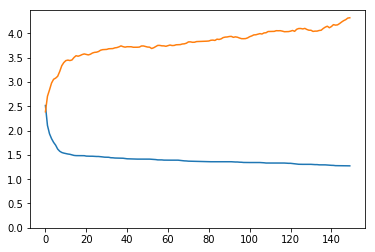

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(ymin=0)

(0, 1)

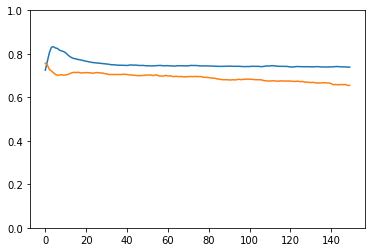

In [46]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylim(ymin=0, ymax=1)

In [32]:
mid1 = g.render_midi(context, f=2)
mid2 = g.render_midi(context, f=3)
x_test = np.stack([midi.encode(context, m) for m in [mid1,mid2]])

WARNING type not == 0
WARNING type not == 0


In [33]:
# maxx = np.maximum(latent[0],latent[1])
# maxx.shape

In [34]:
# arrays = decoder.predict(np.stack([latent[1]]))
arrays = auto.predict(x_train[:1])
arrays.shape

(1, 500, 2)

In [35]:
arrays.max()

6.9216356

(0, 1)

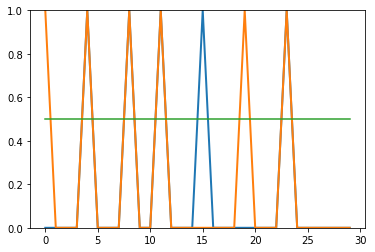

In [47]:
n1 = 30
plt.plot(arrays[0, :n1, 0:].clip(0,1), linewidth=2)
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)

(0, 1)

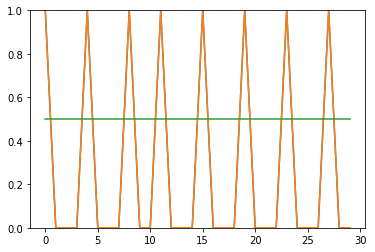

In [48]:
plt.plot(x_train[0, :n1, 0:])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)

In [38]:
mid = midi.decode_track(context, arrays[0])

 [INFO] : 
 |  len, max_t
 |  9.943749999999989
 |  10.0


In [39]:
dn = config.export_dir
io.export_midifile(mid1, dn + 'mid1.mid')
# io.export_midifile(mid2, dn + 'mid2.mid')
io.export_midifile(mid, dn + 'mid_generated.mid')

In [40]:
mid

<midi file None type 1, 1 tracks, 370 messages>

In [25]:
mid

<midi file None type 1, 1 tracks, 374 messages>